Chart created


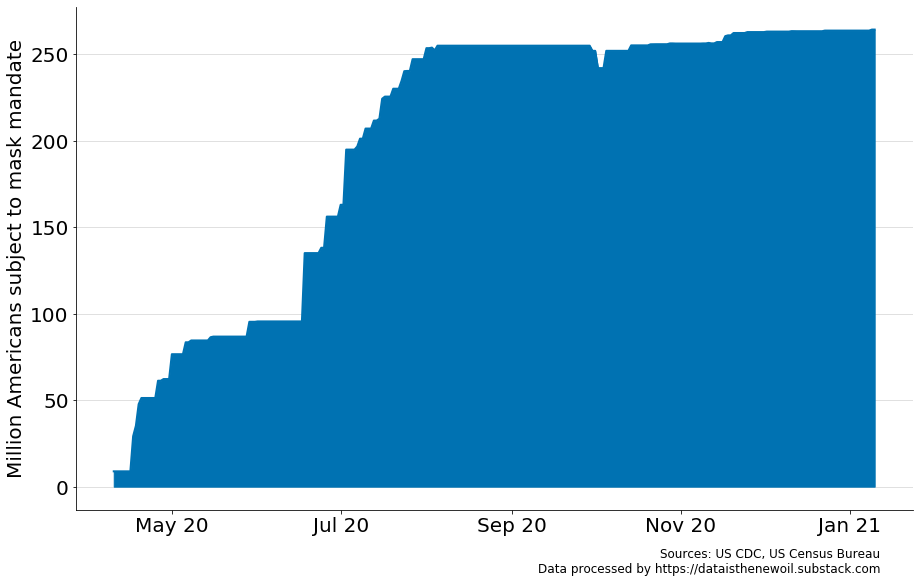

In [21]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, YearLocator, MonthLocator, DayLocator
import datetime
import pandas as pd
import numpy as np

'''First, you should download the US CDC data at https://data.cdc.gov/api/views/tzyy-aayg/rows.csv?accessType=DOWNLOAD'''
'''Then, edit the variable 'link' which currently redirects to a folder on my laptop'''
'''It should match the location of the file on your computer'''

link = '/Users/olivierlejeune/dev/U.S._State_and_Territorial_Public_Mask_Mandates_From_April_10__2020_through_January_10__2021_by_County_by_Day.csv'

def download_and_process_cdc_data():
    df = pd.read_csv(link)
    df['Current_order_status'].replace('No Public Mask Mandate', 0, inplace=True)
    df['Current_order_status'].replace('Public Mask Mandate', 1, inplace=True)
    df['date'] = pd.to_datetime(df['date'])
    df['state-county'] = df['FIPS_State'].astype(str) + df['FIPS_County'].astype(str)
    df['state-county'] = pd.to_numeric(df['state-county'])
    return df

def turn_into_a_pivot_table(df):
    pivot_df = df.pivot_table(index=['state-county'], columns='date', values='Current_order_status')
    return pivot_df

def download_and_process_census_data():
    url = 'https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/counties/totals/co-est2019-alldata.csv'
    county_data = pd.read_csv(url, encoding = "ISO-8859-1")
    county_data['state-county'] = county_data['STATE'].astype(str) + county_data['COUNTY'].astype(str)
    county_data = county_data[county_data['COUNTY']!=0]
    county_data = county_data[['state-county', 'POPESTIMATE2019']]
    county_data['state-county'] = pd.to_numeric(county_data['state-county'])
    county_data['POPESTIMATE2019'] = county_data['POPESTIMATE2019'] / 1000000
    county_data.set_index('state-county', inplace=True)
    return county_data

def merge_cdc_and_census_data(pivot_df, county_data):
    merged_df = pivot_df.join(county_data)
    merged_df.dropna(subset=['POPESTIMATE2019'], inplace=True)
    merged_df = merged_df.multiply(merged_df['POPESTIMATE2019'], axis="index")
    merged_df.drop('POPESTIMATE2019', axis=1, inplace=True)
    merged_df = merged_df.T
    merged_df['Sum'] = merged_df.sum(axis=1)
    return merged_df

def plot_chart(merged_df):
    # main plot label sizes
    SMALL_SIZE = 20
    MEDIUM_SIZE = 20
    BIGGER_SIZE = 22
    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    # plot the data
    # define lines
    line1 = merged_df['Sum']
    # create three objects called 'ax' containing the charts
    fig = plt.figure(figsize=(15,9.25), facecolor="white")
    ax1 = fig.add_subplot(1, 1, 1)
    # define major chart parameters
    ax1.plot(line1, color='#0072B2', linestyle='-', linewidth=2, label='2019')
    ax1.fill_between(line1.index, line1, color='#0072B2')
    plt.grid(b=None, which='major', axis='y', color='#d9d9d9')
    ax1.set_axisbelow(True)
    ax1.spines['left'].set_visible(True)
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.spines['bottom'].set_visible(True)
    ax1.set_ylabel('Million Americans subject to mask mandate')
    # reformat date on x axis
    months = MonthLocator(interval=2)
    myformat = DateFormatter('%b %y')
    ax1.xaxis.set_major_locator(months)
    ax1.xaxis.set_major_formatter(myformat)
    plt.figtext(0.87, 0.03, "Sources: US CDC, US Census Bureau\nData processed by https://dataisthenewoil.substack.com", ha="right", fontsize=12)
    plt.savefig('Masks')
    return print('Chart created')

def run_all_functions():
    df = download_and_process_cdc_data()
    pivot_df = turn_into_a_pivot_table(df)
    county_data = download_and_process_census_data()
    merged_df = merge_cdc_and_census_data(pivot_df, county_data)
    plot_chart(merged_df)
    
run_all_functions()